In [2]:
from os import times

import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def plot_time(t, f_original, f_secondary=None, labels=['Исходная', 'Восстановленная'], xlim=None, path=None):
    plt.figure(figsize=(8,4))
    plt.plot(t, f_original, 'b-', label=labels[0])
    if f_secondary is not None:
        plt.plot(t, f_secondary, 'r--', label=labels[1])
    plt.xlabel('Время t')
    plt.ylabel('Амплитуда')
    if xlim:
        plt.xlim(xlim)
    plt.legend()
    plt.grid(True)
    if path:
        plt.savefig(path)
    plt.show()

def plot_freq(nu, F1, F2=None, labels=['Численный', 'Аналитический'], xlim=None, path=None):
    plt.figure(figsize=(8,4))
    plt.plot(nu, F1, 'b-', label=labels[0])
    if F2 is not None:
        plt.plot(nu, F2, 'r--', label=labels[1])
    plt.xlabel('Частота v')
    plt.ylabel('F(v)')
    if xlim:
        plt.xlim(xlim)
    plt.legend()
    plt.grid(True)
    if path:
        plt.savefig(path)
    plt.show()

In [4]:
def rect(t):
    return np.where(np.abs(t) <= 0.5, 1.0, 0.0)

def analytical_ft(nu):
    return np.sinc(nu)

def numerical_ft_trapezoid(f_t, t, nu):
    F_num = np.zeros_like(nu, dtype=complex)
    for i, freq in enumerate(nu):
        integrand = f_t * np.exp(-2j * np.pi * freq * t)
        F_num[i] = np.trapezoid(integrand, x=t)
    return F_num

def numerical_ft_extend(F_num, V, nu_extended):
    F_num_extended = np.zeros_like(nu_extended, dtype=complex)
    mask = (nu_extended >= -V) & (nu_extended < V)
    F_num_extended[mask] = F_num
    return F_num_extended

def inverse_ft_trapz(F_nu, nu, t):
    f_rec = np.zeros_like(t, dtype=complex)
    for i, time in enumerate(t):
        integrand = F_nu * np.exp(2j * np.pi * nu * time)
        f_rec[i] = np.trapezoid(integrand, x=nu)
    return f_rec

In [ ]:
def task_1_0():
    T = 20.0
    dt = 0.01
    t = np.arange(-T/2, T/2, dt)
    V = 50
    dnu = 1 / T
    nu = np.arange(-V, V, dnu)

    f = rect(t)
    F_analytic = np.sinc(nu)

    plot_freq(nu, F_analytic, labels=['Фурье-образ'], path=f'src/task_1_0/freq_f.png', xlim=(-7, 7))
    plot_time(t, f, labels=['Π(t)'], path=f'src/task_1_0/time_f.png', xlim=(-1.5, 1.5))


task_1_0()

In [ ]:
def task_1_1():
    T_candidates = [5, 50]
    dt_candidates = [1e-2, 5e-4]
    V_candidates = [5, 20]
    dnu_candidates = [0.02, 0.5]
    ft_times = []

    for T in T_candidates:
        for dt in dt_candidates:
            t = np.arange(-T/2, T/2, dt)
            f_t = rect(t)
            for V in V_candidates:
                for dnu in dnu_candidates:
                    nu = np.arange(-V, V, dnu) + dnu/2

                    start_time = time.time()
                    F_num = numerical_ft_trapezoid(f_t, t, nu)
                    ft_time = time.time() - start_time
                    ft_times.append(f"T={T}, dt={dt}, V={V}, dν={dnu}, FT time = {ft_time:.6f} s")
                    f_rec = inverse_ft_trapz(F_num, nu, t).real

                    print(f"T={T}, dt={dt}, V={V}, dν={dnu}, FT time = {ft_time:.6f} s")

                    nu_analytic = np.arange(-V-5, V+5, dnu) + dnu/2
                    F_analytic = analytical_ft(nu_analytic)
                    F_num = numerical_ft_extend(F_num, V, nu_analytic)

                    # plot_freq(nu_analytic, F_analytic, F_num, labels=['Аналитический', 'Численный (trapezoid)'], xlim=(-V-5, V+5), path=f"src/task_1_1/freq_{T}_{dt}_{V}_{dnu}.png")
                    # plot_time(t, f_t, f_rec, labels=['Π(t)', 'Восстановленная Π(t)'], xlim=(-1.5, 1.5), path=f"src/task_1_1/time_{T}_{dt}_{V}_{dnu}.png")
                    plot_freq(nu_analytic, F_analytic, F_num, labels=['Аналитический', 'Численный (trapezoid)'], xlim=(-V-5, V+5))
                    plot_time(t, f_t, f_rec, labels=['Π(t)', 'Восстановленная Π(t)'], xlim=(-1.5, 1.5))
    print(*ft_times, sep='\n')


task_1_1()

In [ ]:
def task_1_2():
    V_fixed = 20
    dnu_fixed = 0.02

    T_candidates = [5, 10]
    dt_candidates = [2e-2, 5e-4]
    ft_times = []

    for T in T_candidates:
        for dt in dt_candidates:
            t = np.arange(-T/2, T/2, dt)
            f_t = rect(t)
            N = len(t)

            dnu = 1.0 / (N * dt)
            n = np.arange(-N//2, N//2)
            nu = n * dnu

            start_time = time.time()
            F_num = np.fft.fftshift(np.fft.fft(f_t)) * dt
            ft_time = time.time() - start_time
            ft_times.append(f"T={T}, dt={dt}, V={V_fixed}, dν={dnu}, FT time = {ft_time:.6f} s")
            f_rec = np.fft.ifft(np.fft.ifftshift(F_num)).real / dt

            print(f"T={T}, dt={dt}, V={V_fixed}, dv={dnu}, FT time = {ft_time:.6f} s")

            F_analytic = analytical_ft(nu)

            # plot_freq(nu_restricted, F_analytic, F_num, labels=['Аналитический', 'FFT'], xlim=(-V_fixed, V_fixed), path=f"src/task_1_2/freq_{T}_{dt}_{V_fixed}_{dnu}.png")
            # plot_time(t, f_t, f_rec.real, labels=['Π(t)', 'Восстановленная Π(t)'], xlim=(-1.5, 1.5), path=f"src/task_1_2/time_{T}_{dt}_{V_fixed}_{dnu}.png")


            plot_freq(nu, F_analytic, F_num, labels=['Аналитический FT', 'FFT'], xlim=(-V_fixed-5, V_fixed+5))
            plot_time(t, f_t, f_rec, labels=['Π(t)', 'Восстановленная Π(t)'], xlim=(-1.5, 1.5))
    print(*ft_times, sep='\n')


task_1_2()

In [ ]:
def task_1_4():
    T_candidates = [5, 10]
    dt_candidates = [0.01, 0.0005]
    V_fixed = 20
    ft_times = []

    for T in T_candidates:
        for dt in dt_candidates:
            t = np.arange(-T/2, T/2, dt)
            f_t = rect(t)
            N = len(t)

            dnu = 1.0 / (N * dt)
            n = np.arange(-N//2, N//2)
            nu = n * dnu

            start_time = time.time()
            F_fft = np.fft.fftshift(np.fft.fft(f_t))
            ft_time = time.time() - start_time
            ft_times.append(f"T={T}, dt={dt}, V={V_fixed}, dν={dnu:.4f}, FT time = {ft_time:.6f} s")

            c = dt * np.exp(2 * np.pi * 1j * nu * (T/2))
            F_corr = F_fft * c

            F_analytic = analytical_ft(nu)

            f_rec = np.fft.ifft(np.fft.ifftshift(F_fft))

            print(f"T={T}, dt={dt}, V={V_fixed}, dν={dnu:.4f}, FT time = {ft_time:.6f} s")
            plot_freq(nu, F_analytic, F_corr, labels=['Аналитический FT', 'Умное FFT'], xlim=(-V_fixed, V_fixed))
            plot_time(t, f_t, f_rec, labels=['Π(t)', 'Восстановленная Π(t)'], xlim=(-1.5, 1.5))
            # plot_freq(nu, F_analytic, F_corr, labels=['Аналитический', 'FFT'], xlim=(-V_fixed, V_fixed), path=f"src/task_1_4/freq_{T}_{dt}_{V_fixed}_{dnu}.png")
            # plot_time(t, f_t, f_rec.real, labels=['Π(t)', 'Восстановленная Π(t)'], xlim=(-1.5, 1.5), path=f"src/task_1_4/time_{T}_{dt}_{V_fixed}_{dnu}.png")

    print(*ft_times, sep='\n')

task_1_4()

In [ ]:
def task_comparative():
    T = 10
    dt = 0.01
    V_fixed = 20

    t = np.arange(-T/2, T/2, dt)
    f_t = rect(t)
    N = len(t)
    ft_times = []

    dnu = 1.0 / (N * dt)
    n = np.arange(-N//2, N//2)
    nu_num = n * dnu

    nu_c = np.arange(-V_fixed, V_fixed, 0.02)
    start_time = time.time()
    F_trapz = numerical_ft_trapezoid(f_t, t, nu_c)
    ft_time = time.time() - start_time
    ft_times.append(f"Trapz: T={T}, dt={dt}, V={V_fixed}, dν={0.02}, FT time = {ft_time:.6f} s")

    f_trapz_rec = inverse_ft_trapz(F_trapz, nu_c, t).real

    start = time.time()
    F_fft = np.fft.fftshift(np.fft.fft(f_t)) * dt
    ft_time = time.time() - start
    ft_times.append(f"fft: T={T}, dt={dt}, V={V_fixed}, dν={dnu}, FT time = {ft_time:.6f} s")

    f_fft_rec = np.fft.ifft(np.fft.ifftshift(F_fft)).real / dt


    c = dt * np.exp(2 * np.pi * 1j * nu_num * (T/2))
    start = time.time()
    F_corr_fft = np.fft.fftshift(np.fft.fft(f_t))
    ft_time = time.time() - start
    ft_times.append(f"smart fft: T={T}, dt={dt}, V={V_fixed}, dν={dnu}, FT time = {ft_time:.6f} s")

    F_corr = F_corr_fft * c
    f_corr_rec = np.fft.ifft(np.fft.ifftshift(F_corr_fft))

    F_analytic = analytical_ft(nu_num)

    plt.figure(figsize=(10,6))
    plt.plot(nu_num, F_analytic, 'k--', label='Аналитический FT')
    plt.plot(nu_c, F_trapz, 'r--', label='Trapz')
    plt.plot(nu_num, F_fft, 'b--', label='Стандартный FFT', alpha=0.5)
    plt.plot(nu_num, F_corr, 'g--', label='FFT с c_m')
    plt.xlabel('Частота ν')
    plt.ylabel('|F(ν)|')
    plt.legend()
    plt.grid(True)
    plt.xlim(-V_fixed, V_fixed)
    plt.savefig(f"src/task_1_4/comp_freq.png")
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(t, f_t, 'k--', label='Π(t)')
    plt.plot(t, f_trapz_rec, 'r--', label='Trapz')
    plt.plot(t, f_fft_rec, 'b--', label='Стандартный FFT', alpha=0.5)
    plt.plot(t, f_corr_rec, 'g--', label='FFT с c_m')
    plt.xlabel('Время t')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.grid(True)
    plt.xlim(-1.5, 1.5)
    plt.savefig(f"src/task_1_4/comp_time.png")
    plt.show()


    print(*ft_times, sep='\n')


task_comparative()

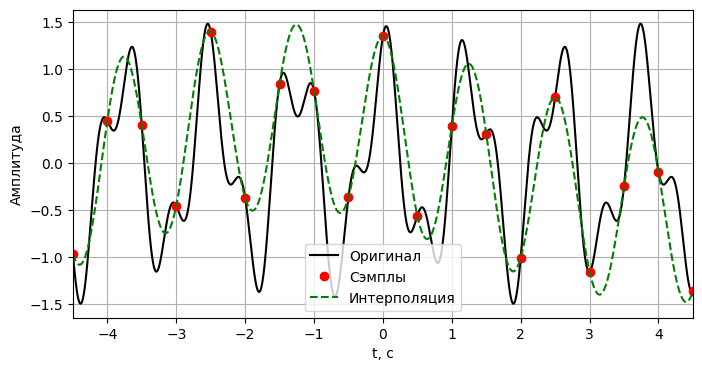

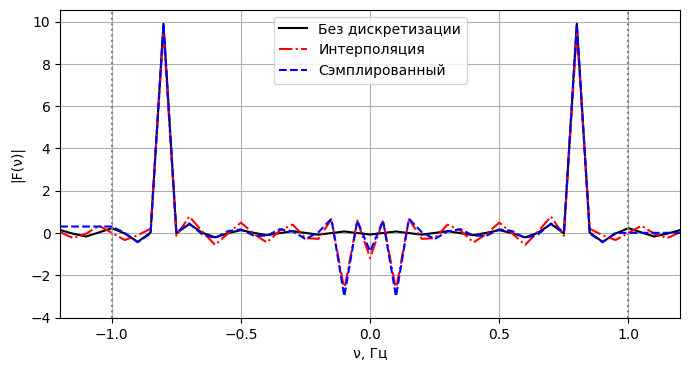

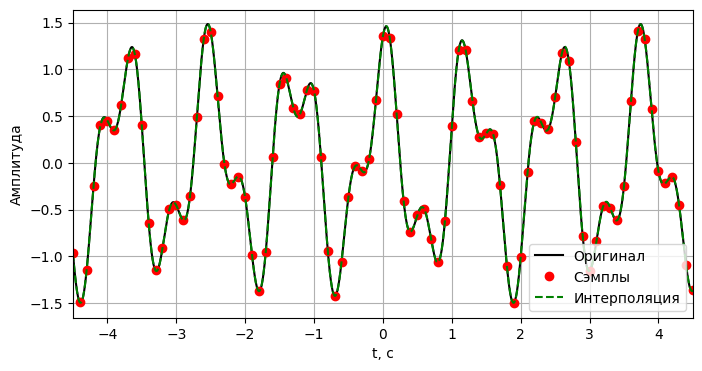

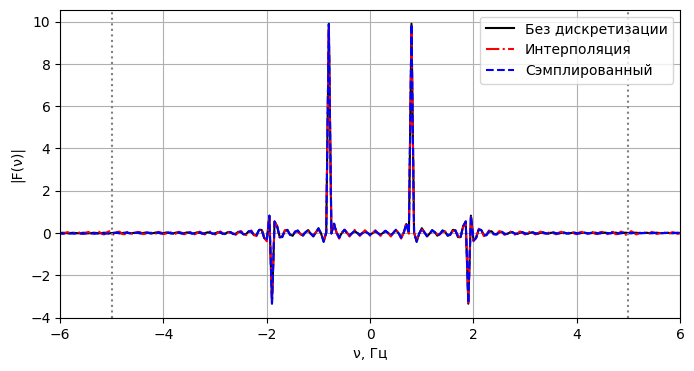

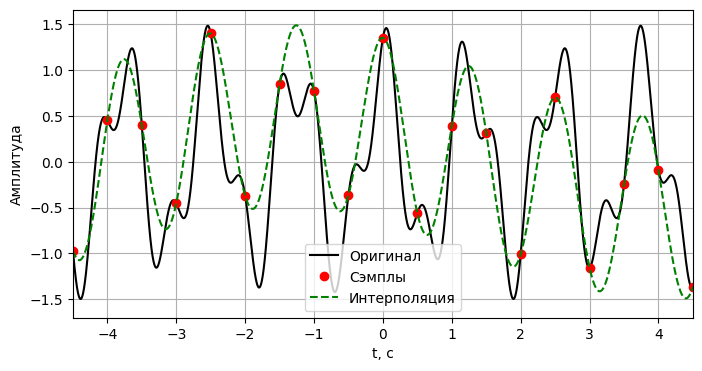

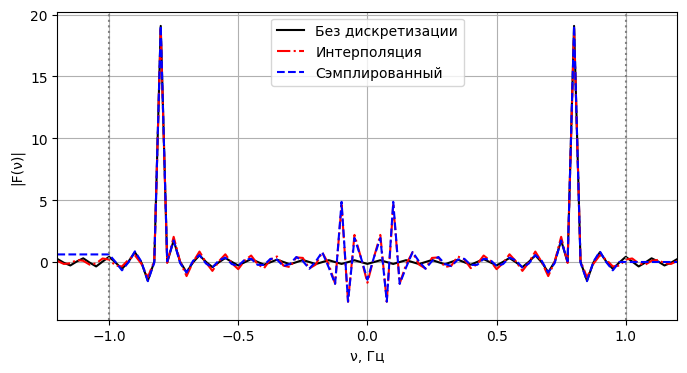

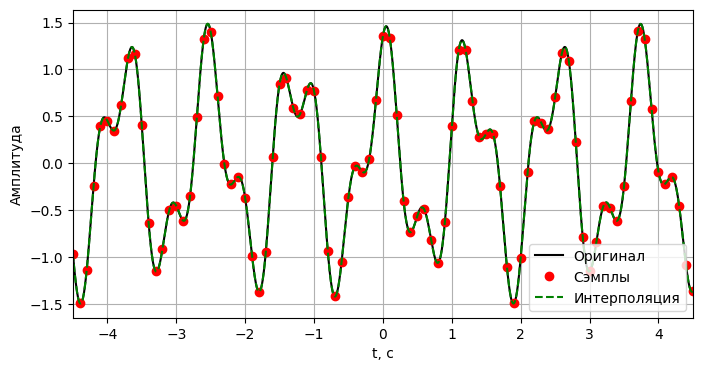

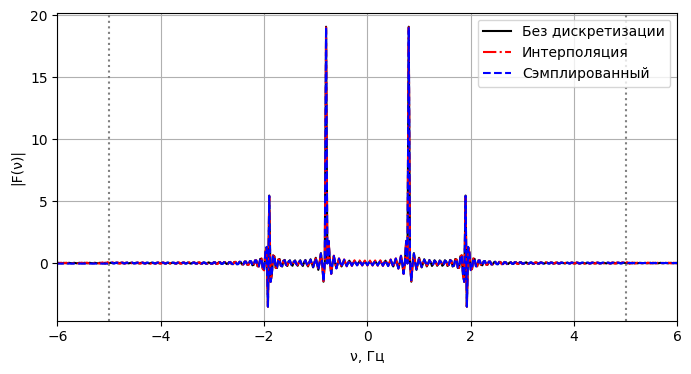

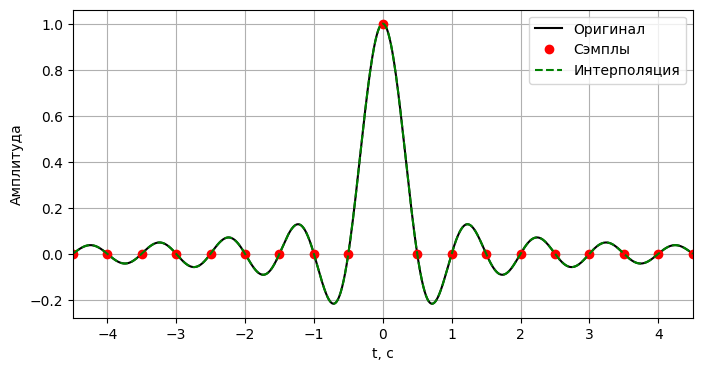

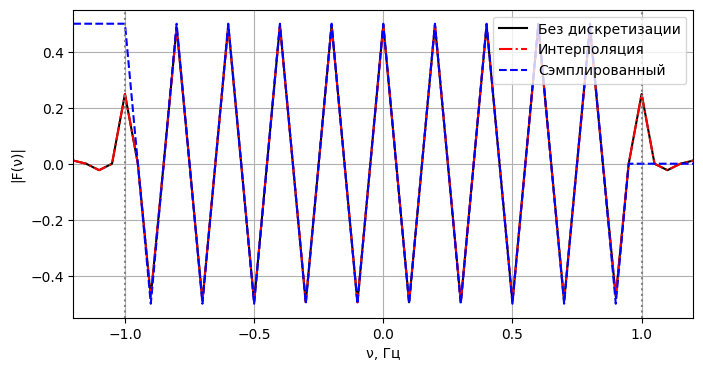

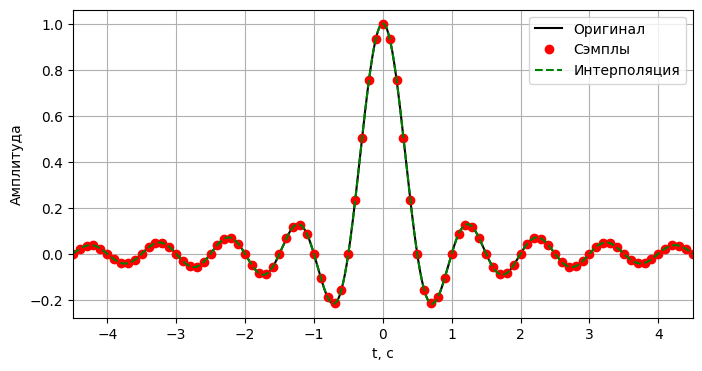

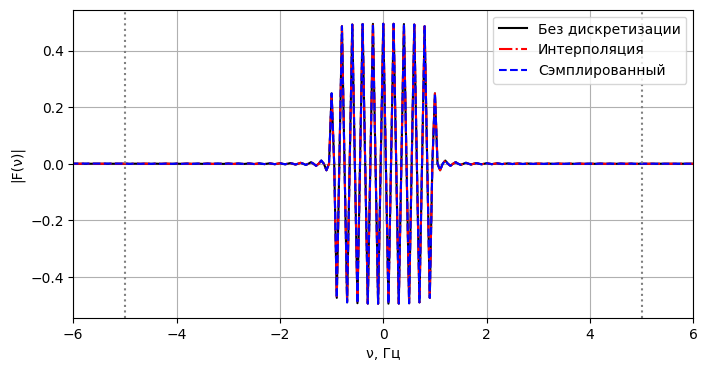

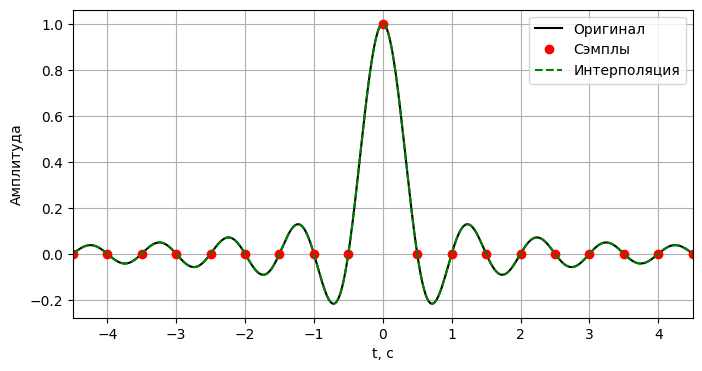

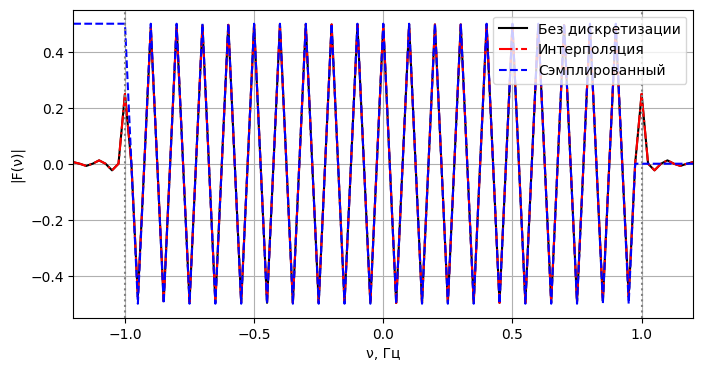

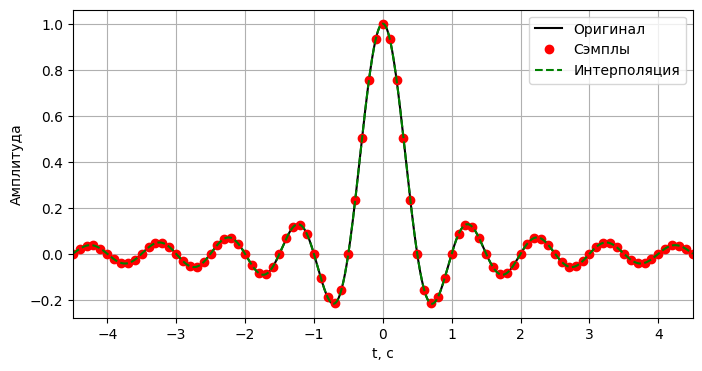

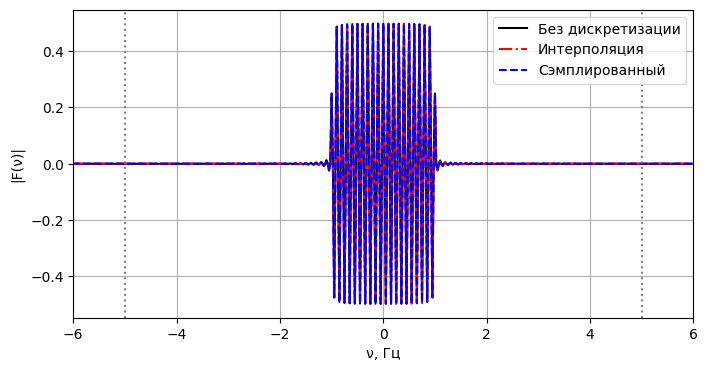

In [158]:
def y1(t, a1=1.0, a2=0.5, w1=5.0, w2=12.0, phi1=np.pi/2, phi2=np.pi/4):
    return a1*np.sin(w1*t + phi1) + a2*np.sin(w2*t + phi2)

def y2(t, b=2.0):
    return np.sinc(b * t)

def fft_smart(f_t, dt, T):
    N = len(f_t)
    dnu = 1.0 / (N * dt)
    n = np.arange(-N//2, N//2)
    nu = n * dnu

    F = np.fft.fftshift(np.fft.fft(f_t))

    c = dt * np.exp(2 * np.pi * 1j * nu * (T/2))
    F *= c
    return F, nu

def nyquist_interpolation(t_dense, t_sample, y_sample, B):
    d = t_dense[:, None] - t_sample[None, :]
    S = np.sinc(2 * B * d)
    return S.dot(y_sample)

def plot_time_signals(t_cont, y_cont, t_samp, y_samp, y_rec, path=None):
    plt.figure(figsize=(8,4))
    plt.plot(t_cont, y_cont, 'k-', label='Оригинал')
    plt.plot(t_samp, y_samp, 'ro', label='Сэмплы')
    plt.plot(t_cont, y_rec, 'g--', label='Интерполяция')
    plt.xlim(t_cont.min(), t_cont.max())
    plt.xlabel('t, с')
    plt.ylabel('Амплитуда')
    plt.xlim(-4.5, 4.5)
    plt.legend()
    plt.grid(True)
    if path:
        plt.savefig(path)
    plt.show()

def plot_spectra(nu, F_cont, F_rec, F_samp, B, path=None):
    plt.figure(figsize=(8,4))
    plt.plot(nu, F_cont, 'k-',  label='Без дискретизации')
    plt.plot(nu, F_rec, 'r-.', label='Интерполяция')
    plt.plot(nu, F_samp, 'b--', label='Сэмплированный')
    plt.axvline(B, color='gray', linestyle=':')
    plt.axvline(-B, color='gray', linestyle=':')
    plt.xlim(-1.2*B, 1.2*B)
    plt.xlabel('ν, Гц')
    plt.ylabel('|F(ν)|')
    plt.legend()
    plt.grid(True)
    if path:
        plt.savefig(path)
    plt.show()

def task2():
    T_list = [10, 20]
    dt_dense = 0.001
    dt_samp_list  = [0.5, 0.1]
    funcs = [y1, y2]
    for i, func in enumerate(funcs, 1):
        for T in T_list:
            t_cont = np.arange(-T, T, dt_dense)
            y_cont = func(t_cont)
            F_cont, nu = fft_smart(y_cont, dt_dense, T)

            for dt_sample in dt_samp_list:
                t_samp = np.arange(-T, T, dt_sample)
                y_samp = func(t_samp)

                B = 1 / (2 * dt_sample)

                F_samp_small, nu_samp = fft_smart(y_samp, dt_sample, T)
                F_samp = np.interp(nu, nu_samp, F_samp_small.real) \
                       + 1j*np.interp(nu, nu_samp, F_samp_small.imag)

                y_rec = nyquist_interpolation(t_cont, t_samp, y_samp, B)
                F_rec, _ = fft_smart(y_rec, dt_dense, T)

                plot_time_signals(t_cont, y_cont, t_samp, y_samp, y_rec)
                plot_spectra(nu, F_cont, F_rec, F_samp, B)
                # plot_time_signals(t_cont, y_cont, t_samp, y_samp, y_rec, path=f"src/task_2/{i}_time_{T}_{dt_sample}.png")
                # plot_spectra(nu, F_cont, F_rec, F_samp, B, path=f"src/task_2/{i}_freq_{T}_{dt_sample}.png")

if __name__ == '__main__':
    task2()